In [1]:
#this notebook was adapted from 
#https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning
#and
#https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb

In [2]:
#import matplotlib pandas etc
using_notebook = True    #use this setting when running in jupyter
#using_notebook = False  #use this setting when running from desktop commandline
#using_notebook = None   #set when this code is running on remote server
if (using_notebook == True):
    %matplotlib inline
if (using_notebook == False):
    import matplotlib
if (using_notebook == None):
    import matplotlib
    matplotlib.use('agg') 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
pd.set_option('display.max_columns', None)

In [3]:
#read bitcoin market data over selected dates
start_date = '20160501'
stop_date = '20180113'
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=" + \
    start_date + "&end=" + stop_date
print url
df = pd.read_html(url)[0]
#convert string dates to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
#daily fractional price change
df['daily_change'] = (df['Close'] - df['Open'])/df['Open']
#subsequent fractional price change
df['next_daily_change'] = df['daily_change'].shift(-1)
#close off high
df['close_off_high'] = 2*(df['High']- df['Close'])/(df['High']-df['Low'])-1
#volatility
df['volatility'] = (df['High'] - df['Low'])/df['Open']
#modify column names
cols = [col + '_bit' for col in df.columns]
cols[0] = 'Date'
df.columns = cols
bitcoin = df
print bitcoin['Date'].dt.date.min(), bitcoin['Date'].dt.date.max()
print bitcoin.dtypes
print bitcoin.shape
bitcoin.tail()

https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20160501&end=20180113
2016-05-01 2018-01-13
Date                     datetime64[ns]
Open_bit                        float64
High_bit                        float64
Low_bit                         float64
Close_bit                       float64
Volume_bit                        int64
Market Cap_bit                    int64
daily_change_bit                float64
next_daily_change_bit           float64
close_off_high_bit              float64
volatility_bit                  float64
dtype: object
(623, 11)


,Date,Open_bit,High_bit,Low_bit,Close_bit,Volume_bit,Market Cap_bit,daily_change_bit,next_daily_change_bit,close_off_high_bit,volatility_bit
4,2018-01-09,15123.7,15497.5,14424.0,14595.4,16660000000,253935000000,-0.034932,0.026377,0.680671,0.070981
3,2018-01-10,14588.5,14973.3,13691.2,14973.3,18500800000,244981000000,0.026377,-0.104381,-1.000000,0.087884
2,2018-01-11,14968.2,15018.8,13105.9,13405.8,16534100000,251387000000,-0.104381,0.039148,0.686445,0.127798
1,2018-01-12,13453.9,14229.9,13158.1,13980.6,12065700000,225986000000,0.039148,0.029228,-0.534801,0.079665
0,2018-01-13,13952.4,14659.5,13952.4,14360.2,12763600000,234391000000,0.029228,NaN,-0.153444,0.050679


In [4]:
#read etherium market data over selected dates
url = "https://coinmarketcap.com/currencies/ethereum/historical-data/?start=" + \
    start_date + "&end=" + stop_date
print url
df = pd.read_html(url)[0]
#convert string dates to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
#daily fractional price change
df['daily_change'] = (df['Close'] - df['Open'])/df['Open']
#subsequent fractional price change
df['next_daily_change'] = df['daily_change'].shift(-1)
#close off high
df['close_off_high'] = 2*(df['High']- df['Close'])/(df['High']-df['Low'])-1
#volatility
df['volatility'] = (df['High'] - df['Low'])/df['Open']
#modify column names
cols = [col + '_ether' for col in df.columns]
cols[0] = 'Date'
df.columns = cols
ethereum = df
print ethereum['Date'].dt.date.min(), ethereum['Date'].dt.date.max()
print ethereum.dtypes
print ethereum.shape
ethereum.tail()

https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20160501&end=20180113
2016-05-01 2018-01-13
Date                       datetime64[ns]
Open_ether                        float64
High_ether                        float64
Low_ether                         float64
Close_ether                       float64
Volume_ether                        int64
Market Cap_ether                    int64
daily_change_ether                float64
next_daily_change_ether           float64
close_off_high_ether              float64
volatility_ether                  float64
dtype: object
(623, 11)


,Date,Open_ether,High_ether,Low_ether,Close_ether,Volume_ether,Market Cap_ether,daily_change_ether,next_daily_change_ether,close_off_high_ether,volatility_ether
4,2018-01-09,1146.00,1320.98,1145.49,1299.74,7965460000,110999000000,0.134154,-0.034237,-0.757935,0.153133
3,2018-01-10,1300.34,1417.38,1226.60,1255.82,9214950000,125976000000,-0.034237,-0.089237,0.693679,0.146715
2,2018-01-11,1268.09,1337.30,1135.17,1154.93,7235900000,122879000000,-0.089237,0.099207,0.804482,0.159397
1,2018-01-12,1158.29,1296.04,1120.09,1273.20,5222300000,112263000000,0.099207,0.099137,-0.740381,0.151905
0,2018-01-13,1270.47,1432.88,1270.47,1396.42,5746760000,123163000000,0.099137,NaN,-0.551013,0.127835


In [5]:
#merge bitcoin and ethereum data
coins = bitcoin.merge(ethereum, on='Date', how='inner')
print coins.shape
print coins.dtypes
coins.head()

(623, 21)
Date                       datetime64[ns]
Open_bit                          float64
High_bit                          float64
Low_bit                           float64
Close_bit                         float64
Volume_bit                          int64
Market Cap_bit                      int64
daily_change_bit                  float64
next_daily_change_bit             float64
close_off_high_bit                float64
volatility_bit                    float64
Open_ether                        float64
High_ether                        float64
Low_ether                         float64
Close_ether                       float64
Volume_ether                        int64
Market Cap_ether                    int64
daily_change_ether                float64
next_daily_change_ether           float64
close_off_high_ether              float64
volatility_ether                  float64
dtype: object


,Date,Open_bit,High_bit,Low_bit,Close_bit,Volume_bit,Market Cap_bit,daily_change_bit,next_daily_change_bit,close_off_high_bit,volatility_bit,Open_ether,High_ether,Low_ether,Close_ether,Volume_ether,Market Cap_ether,daily_change_ether,next_daily_change_ether,close_off_high_ether,volatility_ether
0,2016-05-01,448.48,452.48,447.93,451.88,40660100,6947430000,0.007581,-0.016064,-0.736264,0.010145,8.78,9.01,8.43,8.85,16713800,698377000,0.007973,0.142857,-0.448276,0.066059
1,2016-05-02,451.93,452.44,441.78,444.67,92127000,7002610000,-0.016064,0.012524,0.457786,0.023588,8.89,10.32,8.85,10.16,41019200,708137000,0.142857,-0.084562,-0.782313,0.165354
2,2016-05-03,444.73,451.10,442.62,450.30,59366400,6892690000,0.012524,-0.007686,-0.811321,0.019068,10.17,10.17,9.28,9.31,21463900,809644000,-0.084562,0.003198,0.932584,0.087512
3,2016-05-04,450.18,450.38,445.63,446.72,50407300,6978950000,-0.007686,0.002843,0.541053,0.010551,9.38,10.03,9.27,9.41,17622400,747638000,0.003198,0.045745,0.631579,0.081023
4,2016-05-05,446.71,448.51,445.88,447.98,50440800,6926990000,0.002843,0.026030,-0.596958,0.005887,9.40,10.05,9.29,9.83,18296200,749038000,0.045745,-0.046891,-0.421053,0.080851


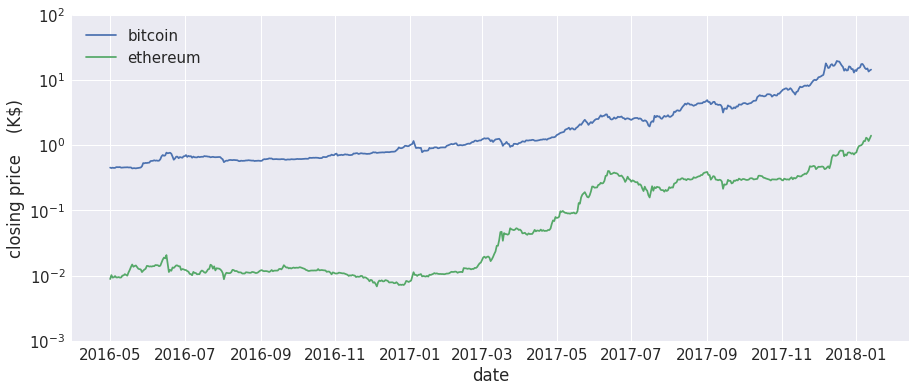

In [6]:
#plot closing prices vs time
fig, ax = plt.subplots(figsize=(15, 6))
xp = coins['Date']
yp = coins['Close_bit']/1000.0
ax.plot(xp, yp, linestyle='-', label='bitcoin')
xp = coins['Date']
yp = coins['Close_ether']/1000.0
ax.plot(xp, yp, linestyle='-', label='ethereum')
ax.set_xlabel('date')
ax.set_ylabel('closing price    (K$)')
ax.set_yscale('log')
ax.set_ylim(0.001, 100)
ax.legend()
plt.show()

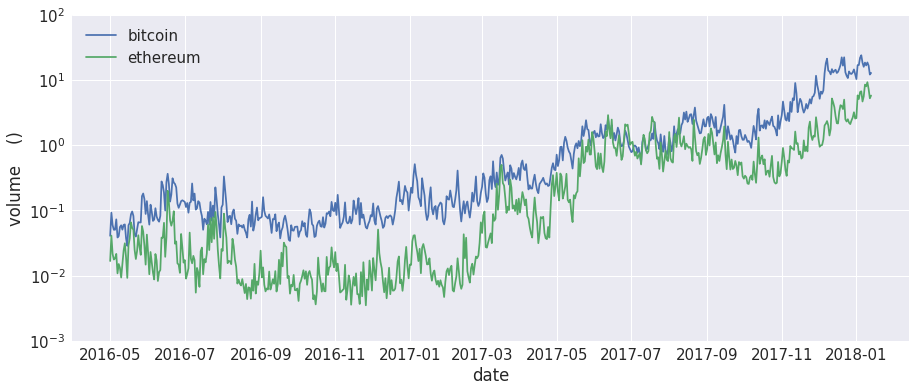

In [7]:
#plot volumes vs time
fig, ax = plt.subplots(figsize=(15, 6))
xp = coins['Date']
yp = coins['Volume_bit']/1.0e9
ax.plot(xp, yp, linestyle='-', label='bitcoin')
xp = coins['Date']
yp = coins['Volume_ether']/1.0e9
ax.plot(xp, yp, linestyle='-', label='ethereum')
ax.set_xlabel('date')
ax.set_ylabel('volume    ()')
ax.set_yscale('log')
ax.set_ylim(1.0e-3, 100)
ax.legend()
plt.show()

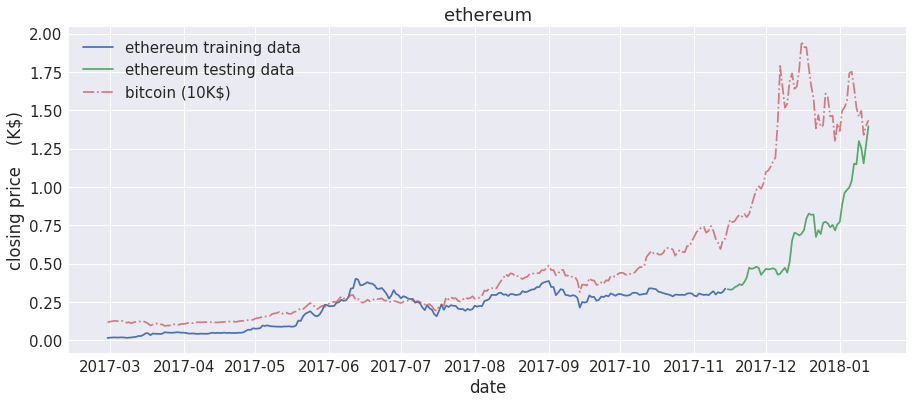

In [8]:
#model will be trained on data collected early 2017, and tested against subsequent data
train_start_date = '2017-02-28'
test_start_date = '2017-11-15'
df = coins
train_idx = (df['Date'] >= train_start_date) & (df['Date'] < test_start_date)
fig, ax = plt.subplots(figsize=(15, 6))
xp = df[train_idx]['Date']
yp = df[train_idx]['Close_ether']/1000.0
ax.plot(xp, yp, linestyle='-', label='ethereum training data')
test_idx = (df['Date'] >= test_start_date)
xp = df[test_idx]['Date']
yp = df[test_idx]['Close_ether']/1000.0
ax.plot(xp, yp, linestyle='-', label='ethereum testing data')
idx = coins['Date'] >= train_start_date
xp = coins[idx]['Date']
yp = coins[idx]['Close_bit']/1.0e4
ax.plot(xp, yp, linestyle='-.', label='bitcoin (10K$)', alpha=0.7)
ax.set_xlabel('date')
ax.set_ylabel('closing price    (K$)')
ax.set_title('ethereum')
ax.legend()
plt.show()

In [20]:
#select index, feature and target columns from records in coins having desired Dates
index_col = 'Date'
feature_cols = ['Close_bit', 'Volume_bit', 'close_off_high_bit', 'volatility_bit',
    'daily_change_bit', 'Close_ether', 'Volume_ether', 'close_off_high_ether',
    'volatility_ether', 'daily_change_ether']
target_col = 'next_daily_change_ether'
xy = coins[feature_cols + [target_col]]
index = coins[index_col]
x = xy[feature_cols]
y = xy[target_col]
print index.shape, x.shape, y.shape, xy.shape
print index.dt.date.min(), index.dt.date.max()
x.tail()

(623,) (623, 10) (623,) (623, 11)
2016-05-01 2018-01-13


,Close_bit,Volume_bit,close_off_high_bit,volatility_bit,daily_change_bit,Close_ether,Volume_ether,close_off_high_ether,volatility_ether,daily_change_ether
618,14595.4,16660000000,0.680671,0.070981,-0.034932,1299.74,7965460000,-0.757935,0.153133,0.134154
619,14973.3,18500800000,-1.000000,0.087884,0.026377,1255.82,9214950000,0.693679,0.146715,-0.034237
620,13405.8,16534100000,0.686445,0.127798,-0.104381,1154.93,7235900000,0.804482,0.159397,-0.089237
621,13980.6,12065700000,-0.534801,0.079665,0.039148,1273.20,5222300000,-0.740381,0.151905,0.099207
622,14360.2,12763600000,-0.153444,0.050679,0.029228,1396.42,5746760000,-0.551013,0.127835,0.099137


In [21]:
#standardize the x-columns
from sklearn import preprocessing
train_idx = (index >= train_start_date) & (index < test_start_date)
scaler = preprocessing.StandardScaler().fit(x[train_idx])
x_scaled = pd.DataFrame(scaler.transform(x), columns=feature_cols, index=y.index)
x_scaled.tail()

,Close_bit,Volume_bit,close_off_high_bit,volatility_bit,daily_change_bit,Close_ether,Volume_ether,close_off_high_ether,volatility_ether,daily_change_ether
618,6.850537,14.016105,1.430306,0.218049,-0.921010,9.421440,13.145627,-1.108191,0.787361,1.556524
619,7.074803,15.708131,-1.391724,0.628446,0.407367,9.041486,15.391979,1.328169,0.702060,-0.632685
620,6.144566,13.900380,1.440001,1.597526,-2.425766,8.168682,11.834013,1.514139,0.870633,-1.347719
621,6.485683,9.793117,-0.610604,0.428876,0.684088,9.191841,8.213933,-1.078729,0.771042,1.102186
622,6.710957,10.434612,0.029737,-0.274872,0.469140,10.257823,9.156815,-0.760897,0.451085,1.101276


In [22]:
#get number of available timesteps, number of lagged timesteps, and number of data features
N_timesteps = x_scaled.shape[0]
N_lagged_steps = 5
N_features = x_scaled.shape[1]
print 'N_timesteps = ', N_timesteps
print 'N_lagged_steps = ', N_lagged_steps
print 'N_features = ', N_features

N_timesteps =  623
N_lagged_steps =  5
N_features =  10


In [23]:
#restack 2D x_scaled array as 3D array = stack of 2D lagged features
x_list = []
for idx, row in x_scaled.iterrows():
    x_sub_df = x_scaled.loc[idx-N_lagged_steps+1:idx]
    x_sub_array = x_sub_df.values
    if (len(x_sub_array) < N_lagged_steps):
        x_sub_array = np.zeros((N_lagged_steps, N_features))
    x_list.append(x_sub_array)
x_array = np.array(x_list)
x_array.shape

(623, 5, 10)

In [24]:
#split x,y into training and testing numpy arrays spanning the desired dates
train_idx = (index >= train_start_date) & (index < test_start_date)
N_timesteps = train_idx.sum()
print 'N_timesteps = ', N_timesteps
x_train = x_array[train_idx]
y_train = y[train_idx].values
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
test_idx = (index >= test_start_date)
x_test = x_array[test_idx]
y_test = y[test_idx].values
print 'x_test.shape = ', x_test.shape
print 'y_test.shape = ', y_test.shape
print 'N_timesteps = ', N_timesteps
print 'N_lagged_steps = ', N_lagged_steps
print 'N_features = ', N_features

N_timesteps =  260
x_train.shape =  (260, 5, 10)
y_train.shape =  (260,)
x_test.shape =  (60, 5, 10)
y_test.shape =  (60,)
N_timesteps =  260
N_lagged_steps =  5
N_features =  10


In [25]:
#import keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout

In [34]:
#this helper function assembles the LSTM model
def lstm_model(N_neurons, input_shape, output_size, activ_func='linear', dropout=0.25, 
        loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(N_neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [35]:
#train LSTM model
N_neurons = 16
input_shape = x_train[0].shape
output_size = 1
N_epochs = 26
np.random.seed(124)
model = lstm_model(N_neurons, input_shape, output_size)
loss_history = model.fit(x_train, y_train, epochs=N_epochs, batch_size=1, verbose=1,
    shuffle=True)

Epoch 1/26
260/260 [==============================] - 2s - loss: 0.1461     
Epoch 2/26
260/260 [==============================] - 2s - loss: 0.1079     
Epoch 3/26
260/260 [==============================] - 2s - loss: 0.0958     
Epoch 4/26
260/260 [==============================] - 2s - loss: 0.0765     
Epoch 5/26
260/260 [==============================] - 2s - loss: 0.0770     
Epoch 6/26
260/260 [==============================] - 2s - loss: 0.0680     
Epoch 7/26
260/260 [==============================] - 2s - loss: 0.0613     
Epoch 8/26
260/260 [==============================] - 2s - loss: 0.0593     
Epoch 9/26
260/260 [==============================] - 2s - loss: 0.0541     
Epoch 10/26
260/260 [==============================] - 2s - loss: 0.0553     
Epoch 11/26
260/260 [==============================] - 2s - loss: 0.0531     
Epoch 12/26
260/260 [==============================] - 2s - loss: 0.0510     
Epoch 13/26
260/260 [==============================] - 2s - loss: 0.0518 

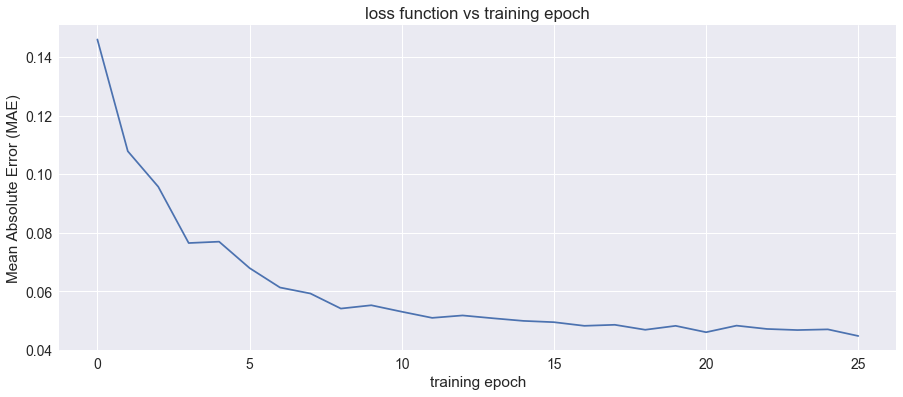

In [29]:
#plot loss function vs training epoch
fig, ax1 = plt.subplots(1,1, figsize=(15, 6))
ax1.plot(loss_history.epoch, loss_history.history['loss'])
ax1.set_title('loss function vs training epoch')
ax1.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_xlabel('training epoch')
plt.show()

In [30]:
#generate predicted y_test = ethereum's fractional next-day gain
col = target_col + '_pred'
y_test_pred = pd.DataFrame(model.predict(x_test), index=index[test_idx], columns=[col])
print x_test.shape, y_test.shape
y_test_pred.head()

(60, 5, 10) (60,)


,next_daily_change_ether_pred
Date,
2017-11-15,0.001566
2017-11-16,0.008065
2017-11-17,-0.002614
2017-11-18,-0.013858
2017-11-19,-0.023494


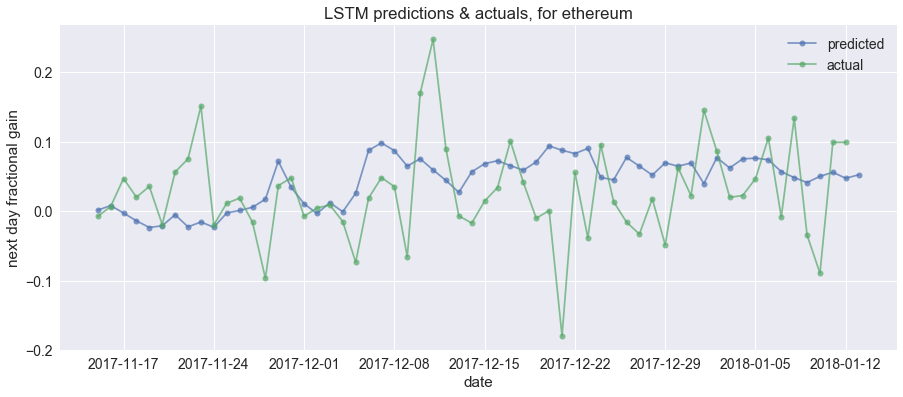

In [37]:
#plot actual and predicted vs date
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(15, 6))
xp = y_test_pred.index
yp = y_test_pred
ax.plot(xp, yp, marker='o', markersize=6, linestyle='-', label='predicted', alpha=0.7)
yp = y_test
ax.plot(xp, yp, marker='o', markersize=6, linestyle='-', label='actual', alpha=0.7)
ax.set_xlabel('date')
ax.set_ylabel('next day fractional gain')
ax.set_title('LSTM predictions & actuals, for ethereum')
ax.legend()
plt.show()